# Ideal Gas Model with Histograms

Suppose we want to graph a histogram of the speeds of atoms in the ideal gas simulation.

Let's start with our simulation.

## Ideal Gas Model

In [1]:
from vpython import *
import numpy as np
import random as rand
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
def check_collisions():
    """Determine all pairs of colliding spheres in the global particles[] list. 
        
    """
    collided_pairs = [] #a list of pairs of spheres that are overlapping
    
    for i in range(N):
        for j in range(i+1,N): #start at i+1 to avoid double counting and to avoid self-collision
            d = mag(particles[i].pos - particles[j].pos)
            if d < 2*R:
                collided_pairs.append([i,j])            
    
    return collided_pairs

In [3]:
def calc_collision(i,j):
    """Calculate new velocity, momentum, and position of pairs of colliding spheres in the global particles[] list. 

    Keyword arguments:
    i -- index of one colliding sphere
    j -- index of second colliding sphere

    """

    global particles
    
    r1 = particles[i].pos
    r2 = particles[j].pos
    v1 = particles[i].v
    v2 = particles[j].v
    p1 = m*v1
    p2 = m*v2
    v1i = v1
    v2i = v2
    
    #transform to reference frame of particle 1
    v2rel = v2 - v1
    r2rel = r2 - r1
    
    #find time when collision ocurred
    dx = dot(r2rel, hat(v2rel))
    dy = mag(cross(r2rel, hat(v2rel)))
    alpha = asin(dy/2/R)
    d = 2*R*cos(alpha) + dx
    deltat = d/mag(v2rel)
    
    #move particles backward in time to their locations at the collision
    particles[i].pos = particles[i].pos - particles[i].v*deltat
    particles[j].pos = particles[j].pos - particles[j].v*deltat
    
    #calculate new momenta using CM reference frame
    r1 = particles[i].pos
    r2 = particles[j].pos
    M = 2*m #total mass
    ptot = p1+p2 #total momentum
    vcm = ptot/M
    v1rel = v1 - vcm
    v2rel = v2 - vcm
    p1rel = m*v1rel
    p2rel = m*v2rel
    r = r2 - r1
    p1rel = p1rel - 2*dot(p1rel,hat(r))*hat(r)
    p2rel = p2rel - 2*dot(p2rel,hat(r))*hat(r)
    v1rel = p1rel/m
    v2rel = p2rel/m
    v1 = vcm + v1rel
    v2 = vcm + v2rel
    p1 = m*v1
    p2 = m*v2
    particles[i].v = v1
    particles[j].v = v2

    #move particles forward in time to their locations at the end of the time step
    particles[i].pos = particles[i].pos + particles[i].v*deltat
    particles[j].pos = particles[j].pos + particles[j].v*deltat
    


In [30]:
scene = canvas(title="N Particles in a Box")

#constants
m = 1.7e-27 #mass of atom in kg
R = 0.5e-10 #radius of atom in m
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 300 #temp in K
s =  np.sqrt(2*3/2*k*T/m) #initial speed

#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

particles = [] #list of particles

N=200 #number of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10
tlist = []
tlist.append(t)

#histogram stuff
histograms = [] #a list of histograms after each time step
deltav = 100 # bin width for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
histograms.append(counts)

#pressure stuff
pressures = [] #list of instantaneous pressure
avepressures = [] #list of average wall pressure
pressures.append(0)#initial pressure is 0 since no collisions at t=0
avepressures.append(0)#initial average pressure is 0 since no collisions at t=0

#evolution
scene.pause()

iterations = 0 #number of iterations of while loop
Nsteps = 1e4 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    dpx = 0 #sum of abs(dp.x) for all particles due to collision with walls
    dpy = 0 #sum of abs(dp.y) for all particles due to collision with walls
    dpz = 0 #sum of abs(dp.z) for all particles due to collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
    
    t = t + dt
    tlist.append(t)
    iterations = iterations+1

    #calculate pressure on walls
    Fx = dpx/dt #instantaneous Fmag on side walls
    Fy = dpy/dt #instantaneous Fmag on top and bottom walls
    Fz = dpz/dt #instantaneous Fmag on front and back walls
    Ftot = Fx+Fy+Fz #total force on walls
    P = Ftot/L**2/6 #total average pressure
    pressures.append(P)
    Pave = (avepressures[-1]*(iterations-1) + P)/iterations
    avepressures.append(Pave)

    #store histogram
    counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
    histograms.append(counts)


<IPython.core.display.Javascript object>

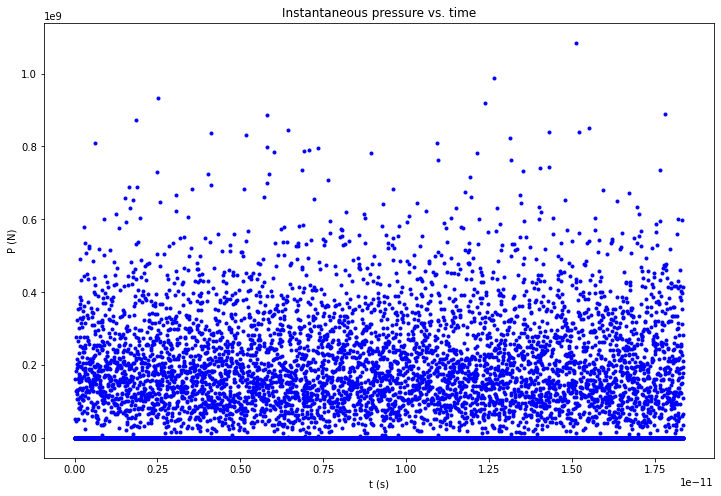

In [31]:
#plot instantaneous pressure
plt.figure(figsize=(12,8))
plt.plot(tlist,pressures,'b.')
plt.title('Instantaneous pressure vs. time')
plt.xlabel("t (s)")
plt.ylabel("P (N)")
plt.show()

from ideal gas law: P =  104999999.99999996 Pa


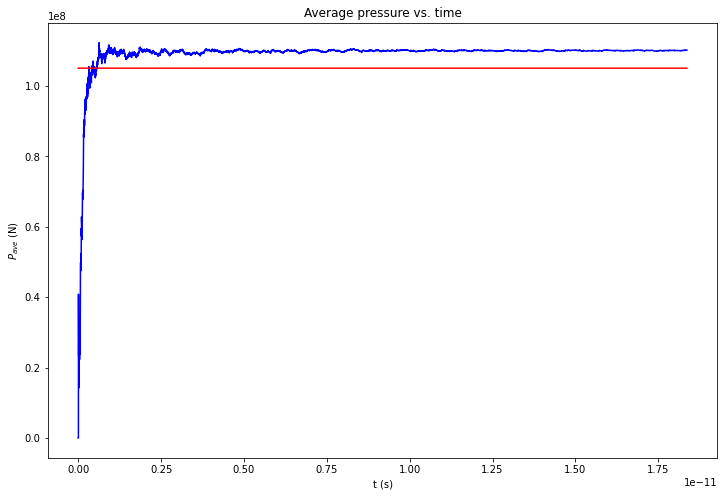

In [32]:
#Calculate theoretical pressure
V=L**3
Ptheor = N*k*T/V
print("from ideal gas law: P = ", Ptheor, "Pa")

#plot average pressure
plt.figure(figsize=(12,8))
plt.title('Average pressure vs. time')
plt.xlabel("t (s)")
plt.ylabel("$P_{ave}$ (N)")
plt.plot(tlist,avepressures,'b-', label='Mean Pressure')
plt.plot(tlist,np.ones(len(tlist))*Ptheor,'r-', label="Theory")
plt.show()

In [6]:
#calculate average histogram
Nhist = len(histograms)
histsum = np.zeros(len(histograms[0]))
for i in range(Nhist):
    histsum = histsum + histograms[i]
histave = histsum/Nhist

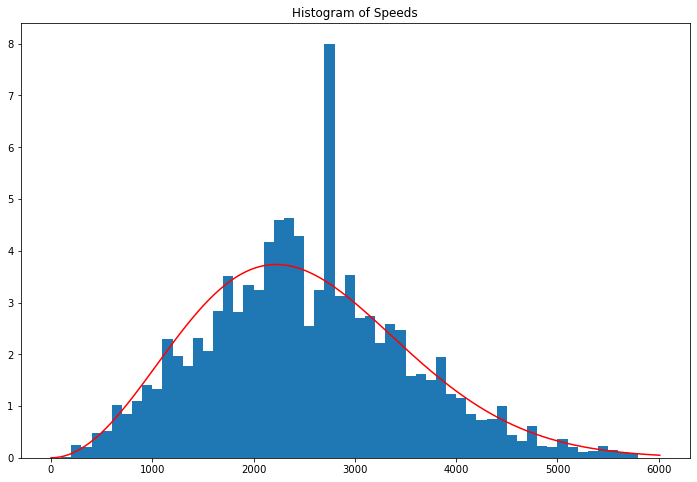

In [8]:
#plot histogram
#calculate speed at center of each bin
centers = [] #store speed at center of each bin
for i in range(len(binx)-1):
    vmiddle = (binx[i] + binx[i+1])/2 #calculate speed at center of bin
    centers.append(vmiddle)

## Add a theoretical plot
dv = 10
Ntheor = []
vtheory = []
for v in range(0,6001+dv,dv):
    Ntheor.append((deltav/dv)*N*4*pi*((m/(2*pi*k*T))**1.5) *exp(-0.5*m*(v**2)/(k*T))*(v**2)*dv ) # theoretical prediction
    vtheory.append(v)

#plot bar graph (histogram)
plt.figure(figsize=(12,8))
plt.bar(centers, histave, align='center', width=deltav)
plt.plot(vtheory,Ntheor,'r-')
plt.title('Histogram of Speeds')
plt.show()